### **Imported Libraries**


*   Nessecary imports


In [10]:
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

### **Loading and Extracting Datasets**


*   location_history is collected by google timeline history
*   spendings_2025 is collected from banking application (Garanti BBVA, credit card statement) and converted to .json file using chatGPT. (All my spendings were made via the related card)



In [11]:

drive.mount('/content/drive')

# Loading expense data
def load_spending_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df["amount"] = pd.to_numeric(df["amount"])
    return df

# Loading location history data
def extract_latlon(location_string, index):
    if location_string and ":" in location_string:
        try:
            coords = location_string.split(":")[-1].split(",")
            return float(coords[index])
        except:
            return None
    return None

def load_visits_from_json(json_path, home_place_id=None):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    visits = []
    for entry in data:
        start = entry.get("startTime")
        end = entry.get("endTime")
        try:
            dt = pd.to_datetime(start)
            if dt.year != 2025:
                continue
        except:
            continue

        if "visit" in entry:
            visit = entry["visit"]
            place = visit.get("topCandidate", {})
            place_id = place.get("placeID")
            if home_place_id and place_id == home_place_id:
                continue  # Skipping my home address
            visits.append({
                "start_time": start,
                "end_time": end,
                "place_id": place_id,
                "latitude": extract_latlon(place.get("placeLocation"), 0),
                "longitude": extract_latlon(place.get("placeLocation"), 1),
                "semantic_type": place.get("semanticType"),
                "probability": place.get("probability")
            })

    df = pd.DataFrame(visits)
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["end_time"] = pd.to_datetime(df["end_time"])
    df["date"] = df["start_time"].dt.date
    df["duration_hours"] = (df["end_time"] - df["start_time"]).dt.total_seconds() / 3600
    return df

# Daily expense summary
def summarize_spending(spending_df):
    return spending_df.groupby("date").agg(
        total_spending=("amount", "sum"),
        transaction_count=("amount", "count")
    ).reset_index()

# Daily count of visits (except my house)
def summarize_visits(visits_df):
    return visits_df.groupby("date").agg(
        location_count=("place_id", "count"),
        time_outside=("duration_hours", "sum")
    ).reset_index()

# Merging the datasets (NA values filled with 0)
def merge_daily_data(spending_summary, visits_summary):
    return pd.merge(spending_summary, visits_summary, how="outer", on="date").fillna(0)

# Main
if __name__ == "__main__":
    spending_json = "/content/drive/My Drive/spendings_2025.json"
    location_json = "/content/drive/My Drive/location-history.json"
    home_place_id = "ChIJK-fZuobXyhQRPvGaa-IDciU" # From google maps
    output_csv = "daily_spending_location_summary.csv"

    # Load data and summarize
    spending_df = load_spending_json(spending_json)
    visits_df = load_visits_from_json(location_json, home_place_id=home_place_id)
    spending_summary = summarize_spending(spending_df)
    visits_summary = summarize_visits(visits_df)

    # Merge and output
    merged_df = merge_daily_data(spending_summary, visits_summary)
    merged_df.to_csv(output_csv, index=False)
    print(merged_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date  total_spending  transaction_count  location_count  time_outside
0  2025-01-01          411.00                1.0             2.0      0.846387
1  2025-01-02         2310.00                1.0             1.0     39.671322
2  2025-01-03         3822.60                3.0             0.0      0.000000
3  2025-01-04          720.00                2.0             1.0      2.001731
4  2025-01-05         3104.44                3.0             1.0      5.232038


### **Plotting Visuals**

1.   Line plot (Spending over time)
2.   Scatter plot (Time outside vs total spending)
3.   Bar plot (Total Spending by number of visited locations)
4.   Box Plot (Spending distribution by weekdays)
5.   Correlaion Heatmap


In [12]:

# Load the merged dataset
df = pd.read_csv("daily_spending_location_summary.csv")
df["date"] = pd.to_datetime(df["date"])
df["weekday"] = df["date"].dt.day_name()

# styling
sns.set(style="whitegrid")



### Plotting Total Spending Over Time


*   Visualizing total spending over time using line plot



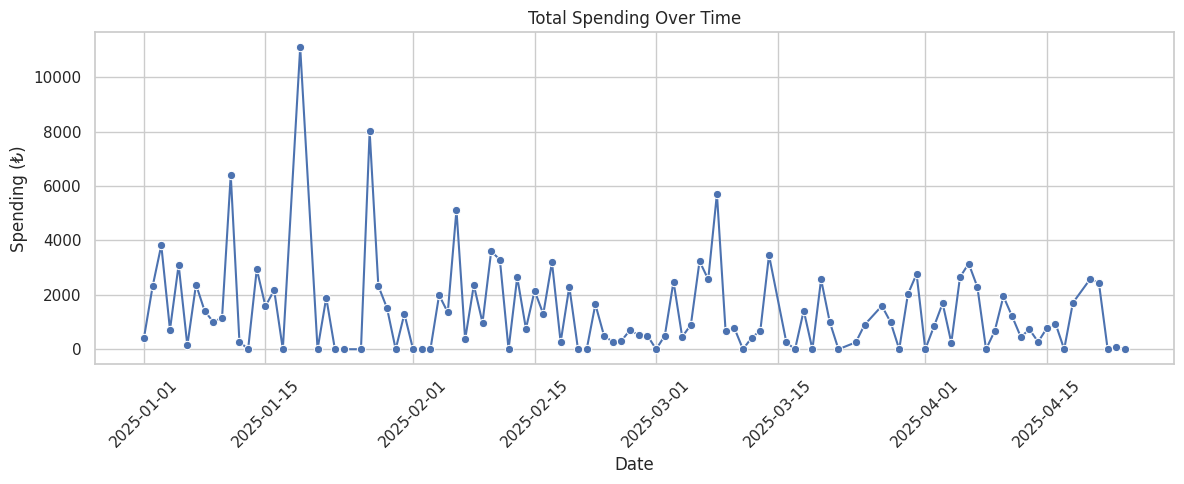

In [13]:
# Line plot (Spending over time)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="date", y="total_spending", marker="o")
plt.title("Total Spending Over Time")
plt.xlabel("Date")
plt.ylabel("Spending (₺)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plot_spending_over_time.png")
plt.show()

### Comparing Time Outside and Total Spending


*   Visalizing the comparison using scatter plot

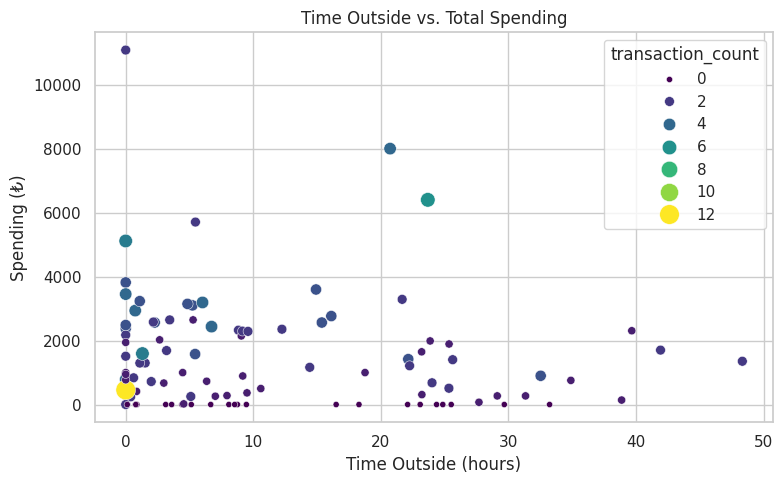

In [14]:
# Scater plot (Time outside vs total spending)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="time_outside",
    y="total_spending",
    size="transaction_count",
    hue="transaction_count",
    palette="viridis",
    sizes=(20, 200)
)
plt.title("Time Outside vs. Total Spending")
plt.xlabel("Time Outside (hours)")
plt.ylabel("Spending (₺)")
plt.tight_layout()
plt.savefig("plot_outside_vs_spending.png")
plt.show()

### Total Spending by Number of Visited Locations


*   Visualizing total spenditure according to the number of locations visited using bar plot



<ipython-input-15-36f1e73ce460>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="location_count", y="total_spending", estimator=sum, ci=None)


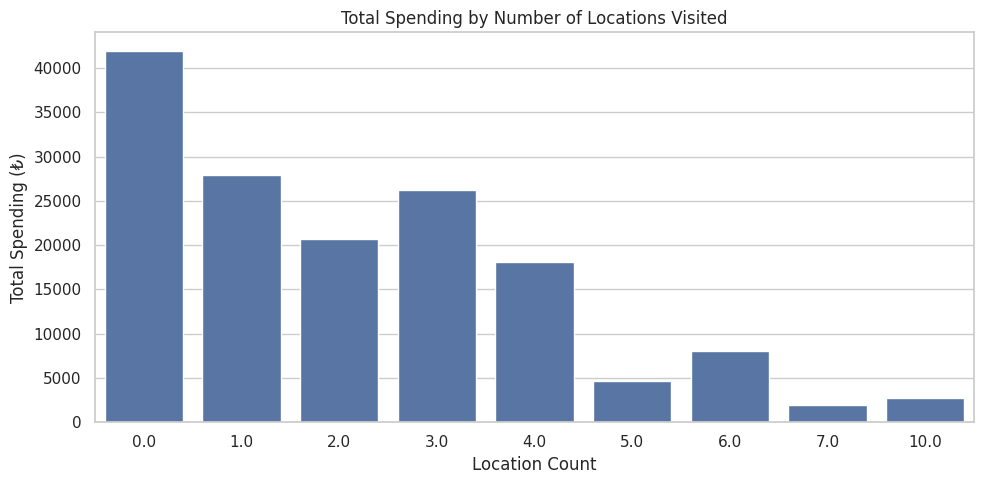

In [15]:
# Bar plot (Total Spending by number of visited locations)
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="location_count", y="total_spending", estimator=sum, ci=None)
plt.title("Total Spending by Number of Locations Visited")
plt.xlabel("Location Count")
plt.ylabel("Total Spending (₺)")
plt.tight_layout()
plt.savefig("plot_spending_by_location_count.png")
plt.show()

### Distrubition of spendings over weekdays


*   Visalizing the distrubition using box plot



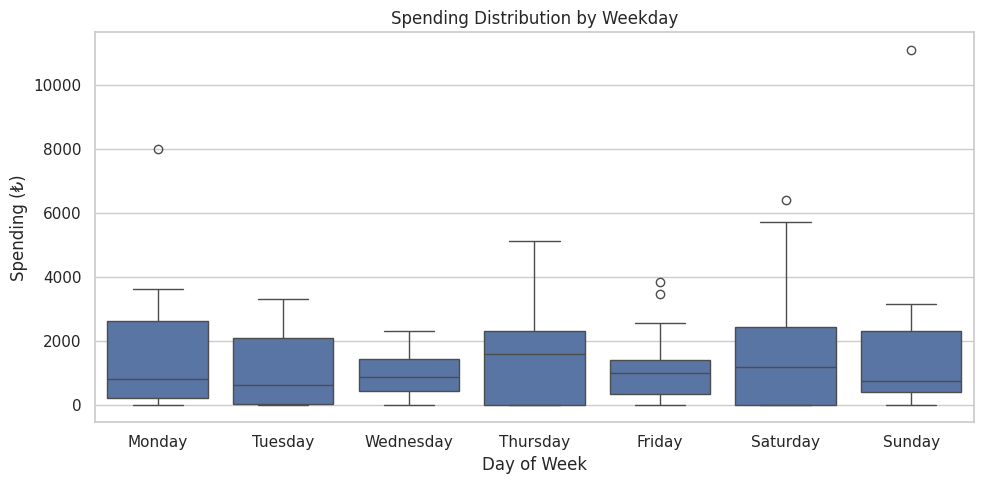

In [16]:
# Box Plot (spending distribution by weekdays)
plt.figure(figsize=(10, 5))
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.boxplot(data=df, x="weekday", y="total_spending", order=weekday_order)
plt.title("Spending Distribution by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Spending (₺)")
plt.tight_layout()
plt.savefig("plot_spending_by_weekday.png")
plt.show()

### Correlation Heatmap


*   Visualizing the correlation of data using heatmap



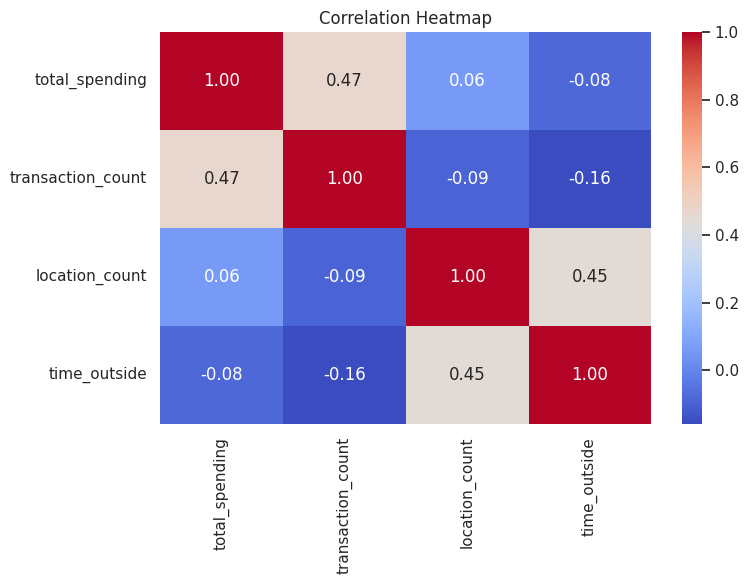

In [17]:
# 5. Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df[["total_spending", "transaction_count", "location_count", "time_outside"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("plot_correlation_heatmap.png")
plt.show()